In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
commands, nums = hp.get_commands_dict('commands.csv')

In [5]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(f'{speaker} data shape: {dataset[speaker]["data"].shape}')
    print(f'{speaker} labels shape: {dataset[speaker]["labels"].shape}')

speaker1 data shape: (550, 400, 13, 1)
speaker1 labels shape: (550, 11)
speaker2 data shape: (440, 400, 13, 1)
speaker2 labels shape: (440, 11)
speaker3 data shape: (440, 400, 13, 1)
speaker3 labels shape: (440, 11)
speaker4 data shape: (440, 400, 13, 1)
speaker4 labels shape: (440, 11)
speaker5 data shape: (550, 400, 13, 1)
speaker5 labels shape: (550, 11)
speaker6 data shape: (550, 400, 13, 1)
speaker6 labels shape: (550, 11)


In [6]:
test_size = 0.3
cnn_test_summary = []
mlp_test_summary = []
threshold_list = [0.5, 0.6, 0.7, 0.8]

In [7]:
def run_experiment(train_list, test_list, train_list_shortname, nn_type, 
                   threshold_list, plot_model=False, plot_cm=True, 
                   cm_save_path=None, tg_save=False):
    print('='*10) 
    print(f'Running experiment\n',
          f'Train dataset : {train_list}\n',
          f'Test dataset : {test_list}\n',
          f'Network type is {nn_type.upper()}.')
    # Set train data
    train_data = []
    train_labels = []
    for speaker in train_list:
        train_data.append(dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...])
        train_labels.append(dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Set test data
    test_data = []
    test_labels = []
    test_dict = dict()
    for speaker in test_list:
        test_data.append(dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...])
        test_labels.append(dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...])
        test_dict[speaker] = {
            'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
            'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
        }
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
        
    print('---Train dataset---')
    print(f'Contains speakers : {train_list}')
    print(f'data shape : {train_data.shape}')
    print(f'labels shape : {train_labels.shape}')
    
    print('---Test dataset---')
    print(f'Contains speakers : {test_list}')
    for speaker in test_list:
        print(f'{speaker} data shape : {test_dict[speaker]["data"].shape}')
        print(f'{speaker} labels shape : {test_dict[speaker]["labels"].shape}')
    
    # Train
    if nn_type == 'mlp':
        model = hp.get_mlp_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/mlp_model.png')
    elif nn_type == 'cnn':
        model = hp.get_cnn_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/cnn_model.png')
        
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_best_only = ModelCheckpoint(save_freq='epoch', save_best_only=True,
                                           filepath='model_checkpoints/experiment2/' + nn_type + '/best_only', verbose=0) 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

    print('---Training stage---')
    history = model.fit(train_data, train_labels, epochs=50, batch_size=256, validation_split=0.15, 
                        callbacks=[early_stopping, checkpoint_best_only], 
                        verbose=0)

    tg_save_path = None
    if tg_save:
        tg_save_path = os.path.join('article', 'img', f'{nn_type}_{train_list_shortname}_train_graphs.png')
    hp.plot_metrics(history, save_path=tg_save_path)
    
    # Test
    print('---Testing stage---')
    for speaker in test_list:
        test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
        print(f"{speaker} - test loss : {test_loss:0.3f} - test accuracy : {test_accuracy:0.3f}")
        
        if nn_type == 'cnn':
            cnn_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])   
        else:
            mlp_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])        
    
    if plot_cm:
        cm_arr = list()
        for threshold in threshold_list:
            cm, metrics = hp.get_confusion_matrix(test_labels, model.predict(test_data), nums, threshold=threshold)
            cm_arr.append({
                'cm': cm, 
                'threshold': threshold,
                'metrics': metrics
            })
            
        if cm_save_path:
            cm_save_path = os.path.join('article', 'img', f'{nn_type}_cm_{cm_save_path}.png')
        hp.plot_confusion_matrix(cm_arr, cm_save_path)
        
        prec_df = None
        for cm in cm_arr:
            if prec_df is None:
                prec_df = pd.DataFrame(cm['metrics'], index=hp.get_commands_list_with_silence(nums)).T
                continue
            prec_df = pd.concat((prec_df, pd.DataFrame(cm['metrics'], index=hp.get_commands_list_with_silence(nums)).T))
        prec_df = prec_df[hp.get_commands_list(nums)]
        display(prec_df)
        
        prec_df.to_csv(os.path.join('article', 'csv', f'{nn_type}_{train_list_shortname}_precisions_for_thresholds.csv'), index=False)
        
    
    print('Finished experiment.')
    print('='*10)       

Running experiment
 Train dataset : ['speaker1']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


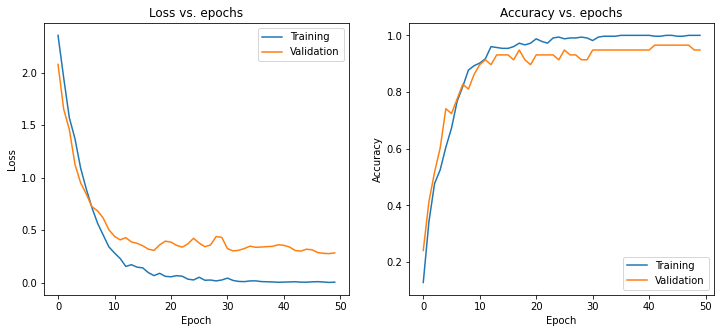

---Testing stage---
speaker1 - test loss : 0.087 - test accuracy : 0.976
speaker2 - test loss : 12.188 - test accuracy : 0.197
speaker3 - test loss : 6.975 - test accuracy : 0.356
speaker4 - test loss : 12.305 - test accuracy : 0.106
speaker5 - test loss : 3.586 - test accuracy : 0.539
speaker6 - test loss : 14.764 - test accuracy : 0.103
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 da

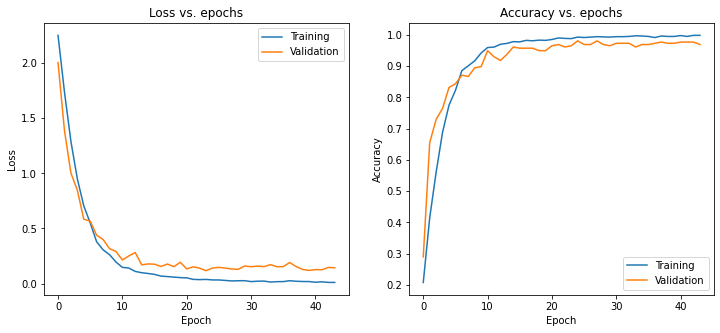

---Testing stage---
speaker1 - test loss : 0.072 - test accuracy : 0.970
speaker2 - test loss : 0.236 - test accuracy : 0.932
speaker3 - test loss : 0.071 - test accuracy : 0.985
speaker4 - test loss : 0.319 - test accuracy : 0.947
speaker5 - test loss : 0.176 - test accuracy : 0.952
speaker6 - test loss : 9.436 - test accuracy : 0.388
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : 

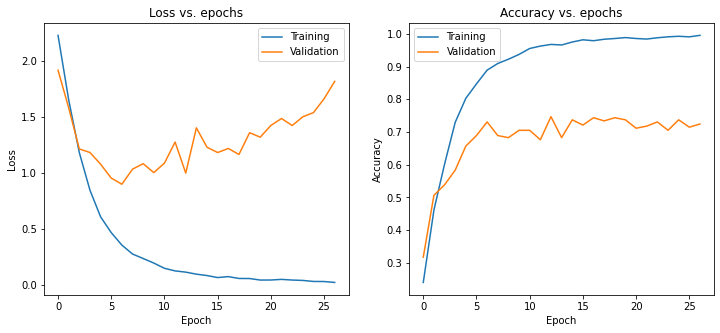

---Testing stage---
speaker1 - test loss : 0.126 - test accuracy : 0.976
speaker2 - test loss : 0.124 - test accuracy : 0.955
speaker3 - test loss : 0.058 - test accuracy : 0.977
speaker4 - test loss : 0.363 - test accuracy : 0.902
speaker5 - test loss : 0.079 - test accuracy : 0.988
speaker6 - test loss : 1.528 - test accuracy : 0.691


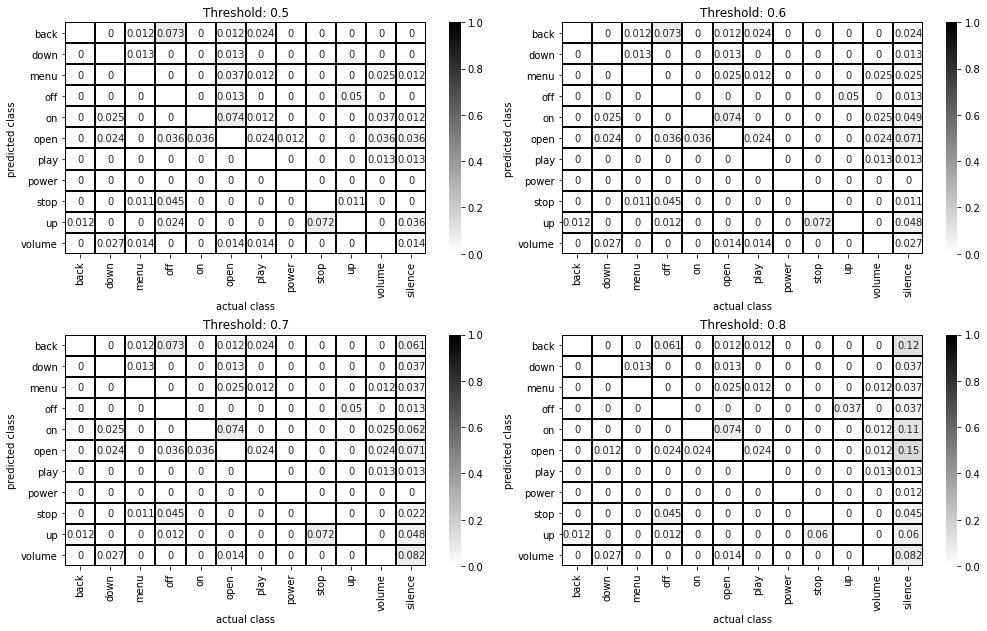

,back,down,menu,off,on,open,play,power,stop,up,volume
precision_for_threshold=0.5,0.878,0.975,0.914,0.938,0.840,0.798,0.974,1.000,0.933,0.855,0.918
precision_for_threshold=0.6,0.854,0.963,0.914,0.938,0.827,0.786,0.974,1.000,0.933,0.855,0.918
precision_for_threshold=0.7,0.817,0.938,0.914,0.938,0.815,0.786,0.974,1.000,0.921,0.855,0.877
precision_for_threshold=0.8,0.793,0.938,0.914,0.925,0.802,0.750,0.974,0.988,0.910,0.855,0.877


Finished experiment.
Running experiment
 Train dataset : ['speaker1']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


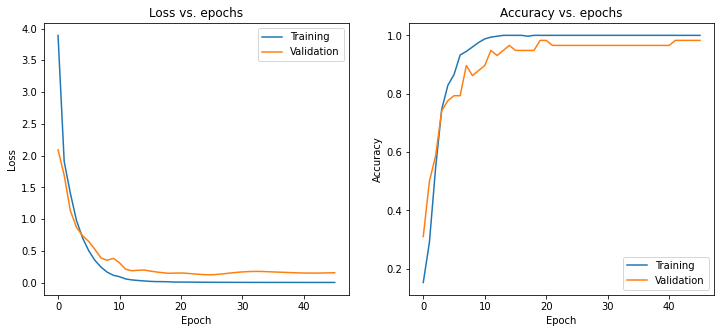

---Testing stage---
speaker1 - test loss : 0.063 - test accuracy : 0.982
speaker2 - test loss : 7.844 - test accuracy : 0.189
speaker3 - test loss : 2.880 - test accuracy : 0.379
speaker4 - test loss : 8.017 - test accuracy : 0.220
speaker5 - test loss : 3.161 - test accuracy : 0.539
speaker6 - test loss : 10.134 - test accuracy : 0.145
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data

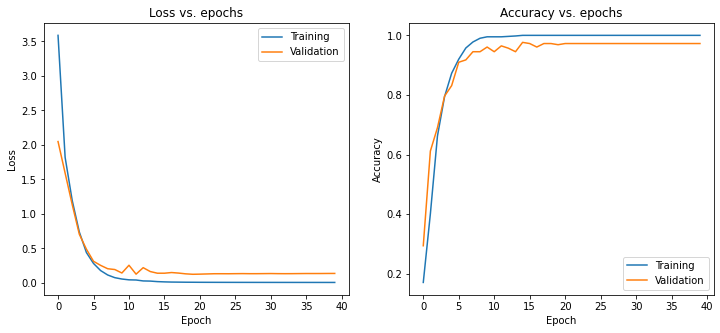

---Testing stage---
speaker1 - test loss : 0.056 - test accuracy : 0.988
speaker2 - test loss : 0.250 - test accuracy : 0.939
speaker3 - test loss : 0.076 - test accuracy : 0.977
speaker4 - test loss : 0.378 - test accuracy : 0.909
speaker5 - test loss : 0.098 - test accuracy : 0.988
speaker6 - test loss : 6.081 - test accuracy : 0.321
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : 

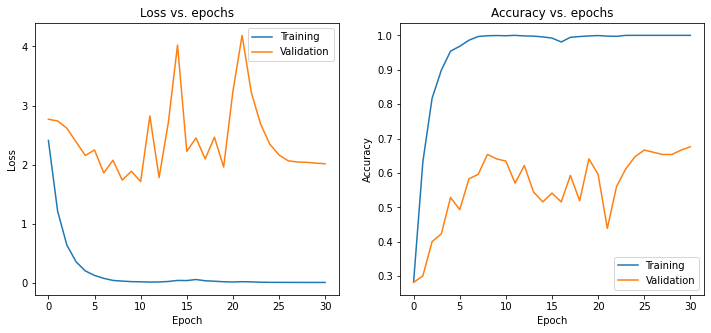

---Testing stage---
speaker1 - test loss : 0.048 - test accuracy : 0.982
speaker2 - test loss : 0.339 - test accuracy : 0.917
speaker3 - test loss : 0.070 - test accuracy : 0.977
speaker4 - test loss : 0.469 - test accuracy : 0.894
speaker5 - test loss : 0.055 - test accuracy : 0.994
speaker6 - test loss : 1.751 - test accuracy : 0.709


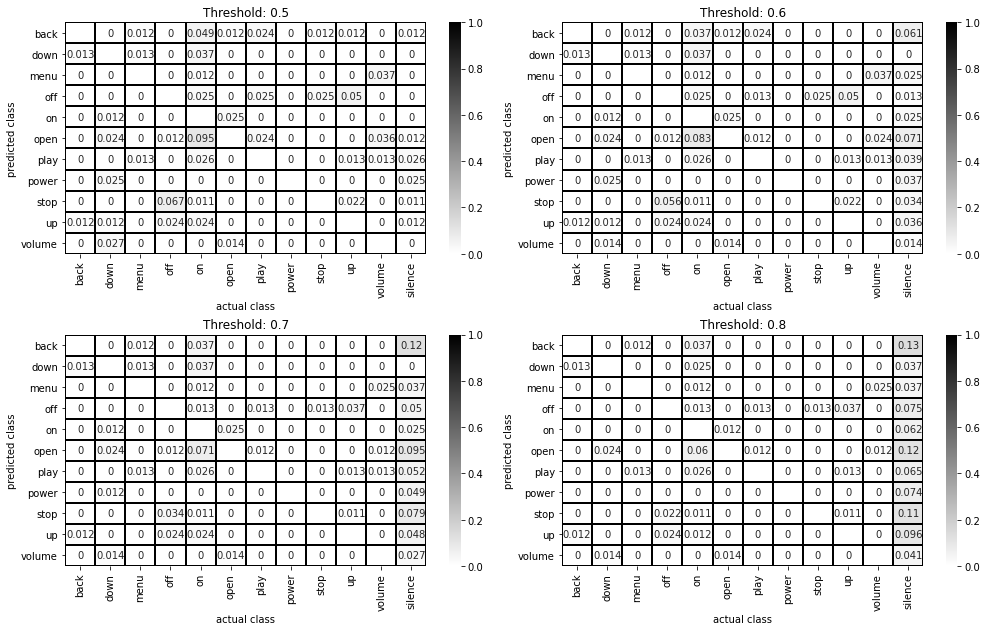

,back,down,menu,off,on,open,play,power,stop,up,volume
precision_for_threshold=0.5,0.866,0.938,0.951,0.875,0.963,0.798,0.909,0.951,0.888,0.916,0.959
precision_for_threshold=0.6,0.854,0.938,0.926,0.875,0.938,0.774,0.896,0.938,0.876,0.892,0.959
precision_for_threshold=0.7,0.829,0.938,0.926,0.875,0.938,0.774,0.883,0.938,0.865,0.892,0.945
precision_for_threshold=0.8,0.817,0.925,0.926,0.850,0.926,0.774,0.883,0.926,0.843,0.855,0.932


Finished experiment.


In [8]:
for nn_type in ['cnn', 'mlp']:
    run_experiment(['speaker1'], all_speakers, 'speaker1', nn_type, threshold_list, True, False, tg_save=True)
    run_experiment(['speaker1','speaker2','speaker3','speaker4','speaker5'], all_speakers, 'all_male_speakers', nn_type, threshold_list, False, False, tg_save=True)
    run_experiment(all_speakers, all_speakers, 'all_speakers', nn_type, threshold_list, False, True, 'all_speakers', tg_save=True)

In [9]:
cnn_cols = ['train_data', 'test_speaker', 'cnn_loss', 'cnn_accuracy']
mlp_cols = ['train_data', 'test_speaker', 'mlp_loss', 'mlp_accuracy']

compare_order = ['train_data', 'test_speaker', 'cnn_loss', 'mlp_loss', 'cnn_accuracy', 'mlp_accuracy']
cnn_df = pd.DataFrame(cnn_test_summary, columns=cnn_cols)
mlp_df = pd.DataFrame(mlp_test_summary, columns=mlp_cols)
cols_to_use = mlp_df.columns.difference(cnn_df.columns)
final_df = pd.merge(cnn_df, mlp_df[cols_to_use], left_index=True, right_index=True, how='outer')[compare_order]
pd.set_option('display.max_colwidth', None)
display(final_df)
final_df.to_csv('article/csv/test_summary.csv', index=False)

,train_data,test_speaker,cnn_loss,mlp_loss,cnn_accuracy,mlp_accuracy
0,speaker1,speaker1,0.087,0.063,0.976,0.982
1,speaker1,speaker2,12.188,7.844,0.197,0.189
2,speaker1,speaker3,6.975,2.880,0.356,0.379
3,speaker1,speaker4,12.305,8.017,0.106,0.220
4,speaker1,speaker5,3.586,3.161,0.539,0.539
5,speaker1,speaker6,14.764,10.134,0.103,0.145
6,all_male_speakers,speaker1,0.072,0.056,0.970,0.988
7,all_male_speakers,speaker2,0.236,0.250,0.932,0.939
8,all_male_speakers,speaker3,0.071,0.076,0.985,0.977
9,all_male_speakers,speaker4,0.319,0.378,0.947,0.909
